In [289]:
import numpy as np
import sklearn
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
import pandas as pd
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from matplotlib import rc
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
from matplotlib.ticker import MaxNLocator

In [290]:
df = pd.read_csv('../csvs/initial_orbital_elements.csv', index_col=0)
del df['instability_time']
del df['Rel_Eerr']
Nrows = df.shape[0]
df.head()
print Nrows, len(np.where(df['Stable']==0)[0])

14999 9075


In [26]:
df_X= df.ix[:,2:]
df_Y=df['Stable']
df_X.head()
#print np.max(df["beta23"])

,RHill12,RHill23,beta12,beta23,m1,a1,P1,e1,pomega1,inc1,...,Omega2,f2,m3,a3,P3,e3,pomega3,inc3,Omega3,f3
0,0.026033,0.023222,8.508586,15.826967,3.414016e-05,1.0,0.999983,0.005031,3.171041,0.008978,...,1.573978,-0.567081,1.826900e-06,1.589043,2.003050,0.002515,-0.108162,0.065498,-1.192440,-0.614709
1,0.022704,0.031284,8.397002,15.367618,2.529838e-07,1.0,1.000000,0.010350,-3.564030,0.001541,...,-1.749616,1.437355,1.955797e-05,1.671403,2.160777,0.072450,-0.343874,0.046939,-0.619350,0.192203
2,0.036304,0.032149,3.461288,25.229467,7.380789e-05,1.0,0.999963,0.051912,0.995149,0.016289,...,-0.032550,-0.317958,1.477931e-07,1.936762,2.695151,0.003395,3.419165,0.014535,2.795101,1.685406
3,0.011704,0.014963,18.513681,19.145889,5.174804e-07,1.0,1.000000,0.000152,-3.328433,0.003301,...,0.946351,-2.294238,1.287851e-06,1.503164,1.842927,0.057380,-0.829096,0.098014,-2.995941,-1.625763
4,0.006199,0.008634,5.494196,2.928938,5.106746e-07,1.0,1.000000,0.001457,1.738448,0.033910,...,-0.455684,-1.074927,1.542321e-06,1.059346,1.090326,0.010325,-1.214839,0.011840,-1.253823,1.215392


In [27]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics   #Additional scklearn functions

Train on the full dataset, then fit on a fixed grid of the two variables wer'e interesteed in, and then use monte carlo simulation to get the values for the rest of the parameters

In [126]:
print df_X.columns.values
model3 = XGBClassifier(seed = 3, learning_rate = 0.01, subsample = 0.9, n_estimators=225, colsample_bytree=0.75, max_depth=9, min_child_weight=4)

['RHill12' 'RHill23' 'beta12' 'beta23' 'm1' 'a1' 'P1' 'e1' 'pomega1' 'inc1'
 'Omega1' 'f1' 'm2' 'a2' 'P2' 'e2' 'pomega2' 'inc2' 'Omega2' 'f2' 'm3' 'a3'
 'P3' 'e3' 'pomega3' 'inc3' 'Omega3' 'f3']


In [37]:
dim = len(list(df_X.columns.values)) -2 # subtract twp because two will remail const
print dim

26


In [30]:
import mcint # monte carlos integration

In [44]:
#Define the D-dimensional Gaussian:
sigma = 2.
def DdimGauss(xvec,sigma,D):
    det = sigma**(2*D)
    norm = 1./(2.*np.pi)**(D/2.)/det**0.5
    return norm*np.exp(-0.5*np.dot(xvec,xvec/sigma**2))

#Define the drawing step:
def draw_sample_Ddim(D):
    return np.random.uniform(-10,10,D) #D-dimensional uniform distribution

def AcceptReject(c,D,P,*Pargs):
    """This function returns `True' if the sample is accepted and `False' if not. We use a
    variable-length argument list `*Pargs' to be able to use any probability function `P' that we
    might come up with"""
    Pval = P(*Pargs)
    proposalval = 1./20**D #The proposal density is 1/20*1/20
    prob = Pval/(c*proposalval)
    return np.random.choice([True,False],p=[prob,1.-prob])

In [46]:
#Draw some samples:
N = 1000000 #number of samples to draw
count = 0 #count the accepted samples
samples = [] #store the accepted samples
D = 5

#Here we are cheating a bit: Since we know what the maximum of the D-dimensional PDF is, we can
#calculate the optimal value of c to use:
c = DdimGauss(np.zeros(D),sigma,D)*20.**D
print 'c =', c

for i in range(N):
    samp = draw_sample_Ddim(D)
    acc = AcceptReject(c,D,DdimGauss,samp,sigma,D)
    if acc:
        count += 1
        samples.append(samp)

print 'acceptance ratio:', 1.*count/N
print samples[:2]

c = 1010.53260138
acceptance ratio: 0.000964
[array([-0.49542184, -3.21049713,  2.47097871, -2.84851974,  0.23163995]), array([ 1.47398862,  0.96575893, -1.89260125,  0.4559712 ,  3.44058147])]


In [47]:
#use another definition of multivariate guassian
from scipy.stats import multivariate_normal
x= np.linspace(0,5,10)
y = multivariate_normal.pdf(x, mean=2.5, cov=0.5)

In [48]:
print y

[ 0.00108914  0.0128652   0.08197202  0.28172908  0.52229358  0.52229358
  0.28172908  0.08197202  0.0128652   0.00108914]


In [291]:
from random import random, uniform , seed
import rebound

def sample_random(seed_val=0):
    a1 = 1. # All distances in units of the innermost semimajor axis (always at 1)
    Mstar = 1. # All masses in units of stellar mass

    logMmin = np.log10(1.e-7) # 1/3 Mars around Sun
    logMmax = np.log10(1.e-4) # 2 Nep around Sun
    logincmin = np.log10(1.e-3)
    logincmax = np.log10(1.e-1) # max mutual inclination of 11.4 degrees. Absolute of 5.7 deg
    seed(seed_val)
    
    
    M1 = 10.**uniform(logMmin, logMmax)
    M2 = 10.**uniform(logMmin, logMmax)
    M3 = 10.**uniform(logMmin, logMmax)
    
    betamin = 1.
    betamax = 30.
    
    hill12 = a1*((M1+M2)/3.)**(1./3.)
    beta1 = uniform(betamin, betamax)
    a2 = a1 + beta1*hill12

    hill23 = a2*((M2+M3)/3.)**(1./3.)
    beta2 = uniform(betamin, betamax)
    a3 = a2 + beta2*hill23

    minhill = min(hill12, hill23)

    ecrit1 = (a2-a1)/a1
    ecrit21 = (a2-a1)/a2
    ecrit23 = (a3-a2)/a2
    ecrit3 = (a3-a2)/a3
    
    logemax1 = np.log10(ecrit1)
    logemax2 = np.log10(min(ecrit21, ecrit23))
    logemax3 = np.log10(ecrit3)

    logemin1 = np.log10(M2/ecrit1**2)
    logemin2 = np.log10(max(M1/ecrit21**2, M3/ecrit23**2))
    logemin3 = np.log10(M2/ecrit3**2)
    
    e1 = min(10.**uniform(logemin1, logemax1), 1.) # make sure ecc < 1
    e2 = min(10.**uniform(logemin2, logemax2), 1.)
    e3 = min(10.**uniform(logemin3, logemax3), 1.)

    i1 = 10.**uniform(logincmin, logincmax)
    i2 = 10.**uniform(logincmin, logincmax)
    i3 = 10.**uniform(logincmin, logincmax)
    
    pomega1=random()*2.*np.pi
    Omega1=random()*2.*np.pi
    
    pomega2=random()*2.*np.pi
    Omega2=random()*2.*np.pi
    
    pomega3=random()*2.*np.pi
    Omega3=random()*2.*np.pi
    
    f1=random()*2.*np.pi # # true anomaly 
    f2=random()*2.*np.pi # # true anomaly 
    f3=random()*2.*np.pi # # true anomaly 

    #return values in same order as they appear in the dataframe
    #['RHill12' 'RHill23' 'beta12' 'beta23' 'm1' 'a1' 'P1' 'e1' 'pomega1' 'inc1'
    #'Omega1' 'f1' 'm2' 'a2' 'P2' 'e2' 'pomega2' 'inc2' 'Omega2' 'f2' 'm3' 'a3'
    #'P3' 'e3' 'pomega3' 'inc3' 'Omega3' 'f3']
    
   

    #use defintion  T = 2pi* (a^3/mu)^0.5, mu = planetmass* G const, but G const here is one?
    G = 4*np.pi**2
    #p1 =2 * np.pi* ((a1**3/M1/G)**0.5) /365.25 #/60. /60. /24. /365.25
    p1 = (a1**3 *4*np.pi**2 /G/(M1+Mstar))**0.5
    p2 = (a2**3 *4*np.pi**2 /G/(M2+Mstar))**0.5
    p3 = (a3**3 *4*np.pi**2 /G/(M3+Mstar))**0.5
        
    #print p1, p2, p3
    
    
    return [hill12, hill23, beta1, beta2, M1, a1, p1, e1, pomega1, i1, Omega1, f1, M2, a2, p2, 
            e2, pomega2, i2, Omega2, f2, M3, a3, p3, e3, pomega3, i3, Omega3, f3]

In [340]:
Nsamples = 100000
cov = np.identity(dim)
rv = multivariate_normal(mean = np.zeros(26), cov= cov) 
data = rv.rvs(Nsamples)
print data.shape
print 50* 2500

(100000, 26)
125000


Note, beta12 and beta34 are the third and fourth samples in the numpy array

In [341]:
beta12 = np.linspace(1, 30, 50) 
beta12 = np.tile(beta12, 50) # 2500 samples, repeat entire list
beta23 = np.linspace(1,30,50)
beta23 = np.repeat(beta23, 50)#, 2500 sample, each element repeats, 
#can only repeat at max the length of the list
#beta12 will always repeat, beta32 will only change a value each time beta12 
#completes a cycle

print beta12[45:55]
print beta23[95:105]

repetitions = 50

repbeta12 = np.repeat(beta12, repetitions)# 125 000 samples
repbeta23 = np.repeat(beta23, repetitions)# 125 000 samples

#repeat both 20 times, so for each block of 20,
#beta 12 and beta23 stays the same, as the rest of the other parameters are varied

print beta23.shape, beta12.shape, planets_data.shape
print beta12[45:55]
print beta23[45:55]

[ 27.63265306  28.2244898   28.81632653  29.40816327  30.           1.
   1.59183673   2.18367347   2.7755102    3.36734694]
[ 1.59183673  1.59183673  1.59183673  1.59183673  1.59183673  2.18367347
  2.18367347  2.18367347  2.18367347  2.18367347]
(2500,) (2500,) (50000, 28)
[ 27.63265306  28.2244898   28.81632653  29.40816327  30.           1.
   1.59183673   2.18367347   2.7755102    3.36734694]
[ 1.          1.          1.          1.          1.          1.59183673
  1.59183673  1.59183673  1.59183673  1.59183673]


In [355]:
planets_data = np.zeros((repbeta12.shape[0], 28)) #= sample_random()
print planets_data.shape[0]
for i in range(planets_data.shape[0]):
    planets_data[i, :] = sample_random(i+3452367)
    #print planets_data[i, :]

125000


In [344]:
print planets_data.shape, repbeta12.shape, repbeta23.shape
print planets_data[:3,:]
print repbeta12[:3]
print repbeta23[:3]

(125000, 28) (125000,) (125000,)
[[  2.60327349e-02   2.32224919e-02   8.50858576e+00   1.58269669e+01
    3.41401602e-05   1.00000000e+00   9.99982930e-01   5.03089897e-03
    3.17104104e+00   8.97829577e-03   1.77083940e+00   6.17502326e+00
    1.87872498e-05   1.22150176e+00   1.35001025e+00   5.93908859e-02
    4.74885787e+00   1.46812853e-02   3.88532699e+00   5.09074503e+00
    1.82689986e-06   1.58904337e+00   2.00310276e+00   2.51451261e-03
    1.57397776e+00   6.54976579e-02   5.71610431e+00   5.66847584e+00]
 [  2.27042329e-02   3.12836905e-02   8.39700175e+00   1.53676175e+01
    2.52983812e-07   1.00000000e+00   9.99999874e-01   1.03501283e-02
    2.71915568e+00   1.54070387e-03   4.78954701e+00   5.93931095e+00
    3.48578993e-05   1.19064748e+00   1.29917372e+00   1.30477081e-02
    1.32327235e-02   1.13944916e-03   2.79845027e+00   5.66383576e+00
    1.95579737e-05   1.67140327e+00   2.16081520e+00   7.24497600e-02
    4.53356973e+00   4.69386082e-02   1.43735543e+00   1

In [351]:
#data_predictions = np.column_stack((data[:,:2], beta12, beta23, data[:,2:]), )
data_predictions = np.column_stack((planets_data[:,:2], repbeta12, repbeta23, planets_data[:,4:]), )
data_predictions.shape

(125000, 28)

In [327]:
print data_predictions[:3,:]

[[  2.60327349e-02   2.32224919e-02   1.00000000e+00   1.00000000e+00
    3.41401602e-05   1.00000000e+00   9.99982930e-01   5.03089897e-03
    3.17104104e+00   8.97829577e-03   1.77083940e+00   6.17502326e+00
    1.87872498e-05   1.22150176e+00   1.35001025e+00   5.93908859e-02
    4.74885787e+00   1.46812853e-02   3.88532699e+00   5.09074503e+00
    1.82689986e-06   1.58904337e+00   2.00310276e+00   2.51451261e-03
    1.57397776e+00   6.54976579e-02   5.71610431e+00   5.66847584e+00]
 [  2.27042329e-02   3.12836905e-02   1.00000000e+00   1.00000000e+00
    2.52983812e-07   1.00000000e+00   9.99999874e-01   1.03501283e-02
    2.71915568e+00   1.54070387e-03   4.78954701e+00   5.93931095e+00
    3.48578993e-05   1.19064748e+00   1.29917372e+00   1.30477081e-02
    1.32327235e-02   1.13944916e-03   2.79845027e+00   5.66383576e+00
    1.95579737e-05   1.67140327e+00   2.16081520e+00   7.24497600e-02
    4.53356973e+00   4.69386082e-02   1.43735543e+00   1.92202532e-01]
 [  3.63043452e-02

In [328]:
model1 = XGBClassifier(n_estimators=225, learning_rate=1, max_depth = 3)
x =df_X.as_matrix()
y = df_Y.as_matrix()
model1.fit(x, y)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=225, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [257]:
0%20 

0

In [352]:
mean_preds = np.zeros(beta12.shape[0]) #want average prediction of each beta12 and beta 23 value
preds = np.zeros(planets_data.shape) #total number or predictions
#do all the testings
# not correct, each pred is only predicting one value, although its a much finer grid
count = 0;

#try a more effiicent solution

preds = model1.predict_proba(data_predictions)[:,1]

In [353]:
print preds.shape, mean_preds.shape, preds[5:10]
count = 0
for i, val in enumerate(preds):
    if i % repetitions ==(repetitions-1):
        #print i
        mean_preds[count]=np.mean(preds[i-19:i])
        count +=1
print mean_preds[:4]
print preds[:4]

(125000,) (2500,) [  5.27701277e-12   9.16229332e-13   9.47575390e-05   4.64773308e-07
   3.39691643e-11]
[  1.91859158e-06   2.51744405e-05   3.25085508e-04   3.16083222e-03]
[  1.32898015e-06   5.75230662e-12   7.33695131e-08   4.56306440e-14]


(2500,) (2500,) (2500,)
[ 0.8019473   0.74665678  0.6283136 ]


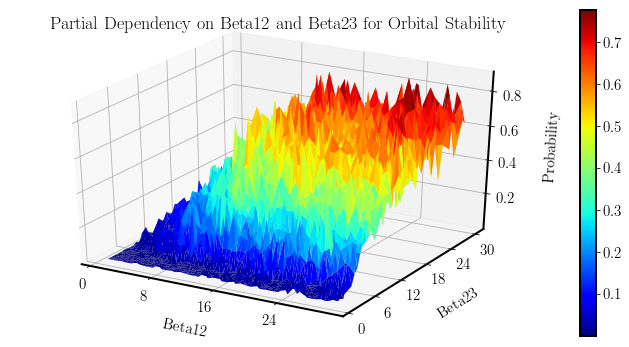

In [354]:
from matplotlib import rc, cm
from mpl_toolkits.mplot3d import axes3d
from matplotlib.ticker import MaxNLocator

rc('text',usetex=True)
rc('font',family='serif')
rc('font',serif='cm')
rc('font',size=15,weight='black',stretch='extra-expanded',style='oblique')
rc('axes',linewidth=2)

fig = plt.figure(figsize = (12,6))
ax = fig.add_subplot(111, projection='3d')

print beta12.shape, beta23.shape, mean_preds.shape
print mean_preds[-3:]

surf = ax.plot_trisurf(beta12, beta23, mean_preds, cmap=cm.jet, linewidth=0)
#surf = ax.scatter(beta12, beta23, mean_preds, cmap=cm.jet, linewidth=0)

fig.colorbar(surf)
ax.tick_params(axis='both', which='major', pad=3)
#ax.rcParams['ytick.major.pad']='8'

ax.xaxis.set_major_locator(MaxNLocator(5))
ax.yaxis.set_major_locator(MaxNLocator(6))
ax.zaxis.set_major_locator(MaxNLocator(5))
ax.set_xlabel('Beta12', labelpad=15)
ax.set_ylabel('Beta23', labelpad=15)
ax.set_zlabel('Probability', labelpad=15)
ax.set_title('Partial Dependency on Beta12 and Beta23 for Orbital Stability')
#ax.plot_surface(x_list, y_list, varyin_pred_mean)
#ax.ad
plt.show()